# <center>  Notebook S01. Differential Mobility Analyzer </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 

This notebook introduces the Differential Mobility Analyzer (DMA) and demonstrates basic functions embedded in the package __DifferentialMobilityAnalyzer.jl__. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

The cylindrical DMA (Knutson and Whitby, 1975) passes a polydisperse aerosol flow through an annulus gap. An electric potential is applied between the inner and outer column. The electric potential drags charged particles through a viscous sheath flow. Particles whose mobility coincide with the electric and flow field forces will be steered to the sample slit. All other particles exit with the excess flow. 

<img src="Figures/nbs1_f01.png" width="400"> 
<b> Figure 1. </b> Schematic of a differential mobility analyzer. The cylindrical differential mobility analyzer is an annular capacitor. The column's properties are defined by the radii $r_1$, $r_2$, the length of the aerosol path, $l$. Operation conditions are defined by the the electric potential $v$ applied across the annulus and the four flow rates: sheath flow, $q_{sh}$, polydisperse aerosol flow $q_a$, excess flow, $q_{ex}$, and monodisperse sample flow, $q_{sa}$. Throughout this work it is assumed that the flows are balanced, i.e. $q_{sh} = q_{ex}$ and $q_{sa} = q_a$. The two flows tracked are $q_{sh}$ and $q_{sa}$. Dimensions and flow range for one commonly used model are provided in Table 1 below. <br>


<center>
<table style="width:45%">
    <caption> <b> Table 1. </b> Geometry of the TSI 3080 long cylindrical DMA column together with typical ranges for operation parameters. </caption>
  <tr>
    <th align="justify">Geometry parameter</th>
    <th align="justify">Value</th> 
    <th align="justify">Operational parameter</th>
    <th align="justify">Range</th> 
</tr>
  <tr>
    <td align="justify">$r_1$</td>
    <td align="justify">9.37×10⁻³ m</td> 
    <td align="justify">$v$</td>
    <td align="justify">± 10-10000 V</td> 
</tr>
  <tr>
    <td align="justify">$r_2$</td>
    <td align="justify">1.961×10⁻² m</td> 
    <td align="justify">$q_{sh}$</td>
    <td align="justify">2-20 L min⁻¹</td> 
</tr>
  <tr>
    <td align="justify">$l$</td>
    <td align="justify">0.44369 m</td> 
    <td align="justify">$q_{sa}$</td>
    <td align="justify">0.3-2 L min⁻¹</td> 
  </tr>
</table>
</center>

## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, DifferentialMobilityAnalyzers, Printf 
plotlyjs();  

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup the DMA 
The Λ structures define the DMAa in terms of flow rates and geometry and power supply polarity. The geometry parameters used in this example correspond to the TSI 3080 long column. The effective diffusion length describes diffusional loss in the DMA column (Reineking & Porstendörfer, 1986) which is described further below. Diffusional loss is ignored if ```leff = 0```. The Λ variable is used in various functions to define the state of the DMA.

<i> Note: DMAType was added during julia v1.0 transition </i>

In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 6                                            # Upper number of charges
DMAtype = :cylindrical                           # specify DMA type 
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,DMAtype)  # Specify DMA with negative polarity
bins,z₁,z₂ = 128, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices
Λp = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:+,m,DMAtype) # Specify DMA with positive polarity
δp = setupDMA(Λp, z₁, z₂, bins);                 # Compute matrices
fieldnames(DifferentialMobilityAnalyzer)         # Print a list of variables constained in δ

(:Ω, :Tc, :Tl, :Z, :Ze, :Dp, :De, :ΔlnD, :𝐀, :𝐒, :𝐎)

The code generates a ```δ``` structure that contains the main language elements for the computations performed in subsequent notebooks. Specifically, it contains the various convolution matrices and defines the size grid in terms of the number of bins and lower and upper diameters. ```Tc``` is the charge efficiency function, ```Tl``` is the penetration efficiency function (see below), ```Z``` are the mobility bin midpoints, ```Dp``` are the diameter bin midpoints (internally in units of nm), ```Ze``` are the mobility bin edges, ```De``` are the diameter bin edges, ```ΔlnD``` is the natural log ratio of upper and lower diameter bin edge, and ```𝐀```, ```𝐒```, and ```𝐎``` are convolution matrices. 

## Block 3. DMA Functions
This block describes (a) the Cunningham slip-flow correction, (b) the particle diffusion coefficient, (c) the relationship between v, zp, and dp, (d) the penetration efficiency of particles transitting through the DMA, (e) the charging efficiency of the bipolar charger, and (f) the transfer function of particles selected by the DMA.
### (a) Cunningham slip-flow correction/mean free path: 
The slip flow correction, $c_c$ [-], accounts for the decreased drag particles experience relative to Stokes' drag force when particle size approaches the scale of the mean free path of air. It is computed following Hinds (1999) Eq. 3.20
<center> $c_c = 1+\frac{\lambda}{d_p} \left(2.34+1.05 \exp \left[-0.39 \frac{d_p}{\lambda}\right]\right)$ </center>
where $d_p$ is the particle diameter and $\lambda = 6.6 \times 10^{-8}\frac{101315}{p}\frac{t}{293.15}$ is the mean free path of air as a function of pressure $p$ [Pa] and temperature $t$ [K]. 

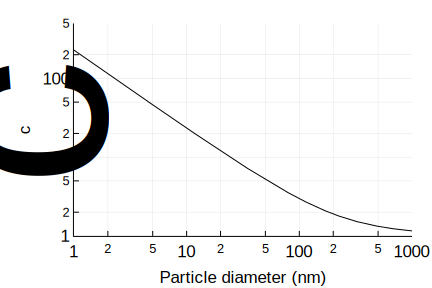

In [3]:
figure("Nimbus Sans L", 2, 3, 2, 8)
Dp = exp10.(range(log10(1e-9), stop=log10(1000e-9), length=1000))
plot(Dp*1e9, cc(Λ,Dp), xscale = :log10, yscale = :log10, xlim = (1, 1000), ylim = (1, 500), yticks = [1, 10], 
    xlabel = "Particle diameter (nm)", color = :black, ylabel = "c<sub>c</sub> (-)", legend = :none, 
    right_margin = 20px, fmt = :svg)

<b> Figure 2.</b> Size dependence of Cunningham slip flow correction factor. Also see Hinds (1999) Figure 3.3.

### (b) Particle diffusion coefficient/air viscosity: 
The diffusion coefficient of particles in in air, $d_{ab}$, describes the random displacement of particles due to Brownian motion. Here it is computed via the Stokes-Einstein relation (Hinds, 1999, Eq. 7.20)
<center> $d_{ab} = \frac{k_bTc_c}{3\pi\eta d_p}$ </center>
where $k_b$ is Boltzmann's constant and $\eta = 1.83245\times10^{-5} \exp \left(1.5 \ln \left[\frac{T}{296.1}\right]\right)\left (\frac{406.55}{T+110.4} \right)$ is the viscosity of air [Pa s] as a function of temperature [K]. <br> <br>
The function ```dab(Λ,dp)``` is defined in dmafunctions.jl, where Λ contains pressure and temperature and Dp is a vector of particle diameter in [m] and ```dab(Λ,dp)``` is in [m² s⁻¹].

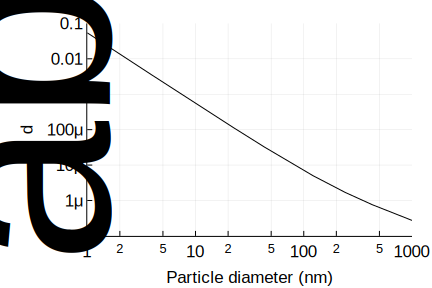

In [4]:
plot(Dp*1e9, dab(Λ,Dp)*1e4, xscale = :log10, yscale = :log10, xlim = (1, 1000), ylim = (1e-7, 1e-1), 
    label = "d<sub>ab</sub>", color = :black, yticks = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
    ylabel = "d<sub>ab</sub> (cm² s⁻¹ )", xlabel = "Particle diameter (nm)", 
    legend = :none, right_margin = 20px,fmt=:svg)

<b> Figure 3. </b> Size dependence of particle diffusion coefficient. Also compare to Hinds Table 7.1.

### (c) Relationship between v, z, and dp: 
For the cylindrical DMA and balanced flows, the relationship between $v$, $z^s$, and $d_p$ is given by Knutson and Whitby (1975)
<center> $z^s = \frac{q_{sh}}{2\pi l v} \ln \left(\frac{r_2}{r_1}\right)$ </center>
where $v$ is the potential applied between the inner and out section of the annulus. The relationship between $d_p$ and $z^s$ is 
<center> $d_p =  \frac{kec_c}{3\pi \eta z^s}$ </center>
where $e$ is the elementary charge and $k$ is the number of charges on the particle. <br> 

The function ```vtov(Λ,v)``` is defined in DifferentialMobilityAnalyzer.jl, where Λ subsumes the DMA geometery (r1,r2,l), sheath flow rate, and t,p to compute $c_c$ and η. The function ```dtoz(Λ,d)``` converts diameter to particle mobility. The function ```ztod(Λ,k,z)``` converts mobility to mobility diameter for particles carrying k charges. This function requires iteration since one of the arguments, cc, also depends on particle diameter. Example conversions using these functions are shown below.

In [5]:
k = 1
v = 1000
z = vtoz(Λ,v)
dp = ztod(Λ,k,z)
@printf("V = %i V corresponds to Z = %.2e []\n", v, z)
@printf("Z = %.2e [] and n = %i charge(s) corresponds to Dp = %i nm\n", z,k,dp)
@printf("Dp = %i nm and n = 1 charge corresponds to Zp = %.2e nm\n", dp,dtoz(Λ,dp*1e-9))

V = 1000 V corresponds to Z = 2.20e-08 []
Z = 2.20e-08 [] and n = 1 charge(s) corresponds to Dp = 114 nm
Dp = 114 nm and n = 1 charge corresponds to Zp = 2.20e-08 nm


### (d) Peneration efficiency through the DMA: 
Penetration efficiency through the DMA is computed based on the parameterized results by Reineking & Porstendörfer (1986).
<center> $T_l = 0.82\exp(-11.5u)+0.1\exp(-70.0u)+0.03\exp(-180.0u)+0.02\exp(-340.0u)$ </center>
where $u = \frac{d_{ab} l_{eff}}{q_{sa}}$, $l_{eff}$ is the parameterized effective diffusion length, and $q_{sa}$ is the aerosol flow rate through the DMA. <br> <br>
The function Tl(Λ,dp) is defined in DifferentialMobilityAnalyzer.jl, where Λ contains the effective length, aerosol flow rate, and $t$,$p$ to compute $d_{ab}$. The article diameter $d_p$ is in [nm]. To treat multiple DMAs with different {$l_{eff}$, $q_sa$, $t$, $p$} in a single scipt, the function Tl is appropriately embedded in the structure δ.

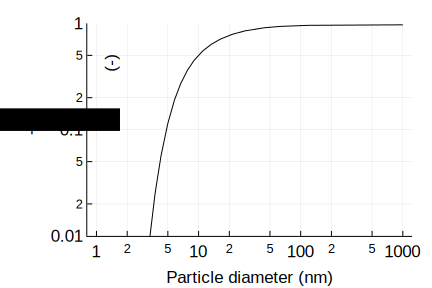

In [6]:
p3 = plot(Dp*1e9, δ.Tl(Λ,Dp*1e9), xscale = :log10, yscale = :log10, ylim = (0.01, 1), color = :black,
    yticks = [0.01, 0.1, 1.0], ylabel = "T<sub>l</sub> (-)",xlabel = "Particle diameter (nm)",  
    legend = :none, right_margin = 20px,fmt=:svg)

<b> Figure 4. </b> Size dependence of penetration efficiency through the DMA for $l_{eff}$ specified in Block 2. Note that the function ```δ.Tl(Λ,Dp*1e9)``` takes diameter in units of nm. Also compare to Figure 2 in Reineking and Porstendorfer (1986).

### (e) Charging efficiency: 
Charging efficiency (charge equilibrium) obtained in the bipolar charger is computed based on the parameterized measurements by Wiedensohler et al. (1988) with coefficients taken from the TSI 3080 Manual (2009). 
<center> $T_c(k) = 10^\left\{ \sum_{i=1}^6 a_i (k) \left[ \ln \left(\frac{D_p}{nm}\right) \right]^{i-1} \right \}$ </center>
where $k = -2,-1,1,2$ is the number and polarity of particle charge and $a_i$ are empirical coefficients. <br> <br>
The function ```Tc(k)``` is defined in module DifferentialMobilityAnalyzer.jl. It return the charging efficiency for n charges. Each function belongs to a DMA structure, which sets the internal diameter grid and polarity. In this script, the function ```δ.Tc``` is for negative polarity and ```δp.Tc``` for positive polarity as defined in Block 2. The function is computes charging efficiencies on the DMA internal grid ```δ.dp```, which is set by the mobility range and the number bins.

In [7]:
println("Table 1. Coefficients aᵢ(n) for negative (n) and positive (p) charging efficiency");
DifferentialMobilityAnalyzers.ax

Table 1. Coefficients aᵢ(n) for negative (n) and positive (p) charging efficiency


,n2,n1,p1,p2
,Float64,Float64,Float64,Float64
1,-26.3328,-2.3197,-2.3484,-44.4756
2,35.9044,0.6175,0.6044,79.3772
3,-21.4608,0.6201,0.48,-62.89
4,7.0867,-0.1105,0.0013,26.4492
5,-1.3088,-0.126,-0.1553,-5.748
6,0.1051,0.0297,0.032,0.5049


For $k \ge \pm 3$, the formula from the TSI manual is used:
<center> $T_c(k) = \frac{e}{\sqrt{4\pi^2\epsilon D_pk_bT}} \exp \left( \frac{-\frac{\left[|k| - 2\pi\epsilon D_pk_bT \ln(0.875)\right]^2}{e^2}}{ \frac{4\pi\epsilon D_pk_bT}{e^2}} \right) $</center>
where $e$ is the elementary charge and $\epsilon$ is the dielectric constant for air.

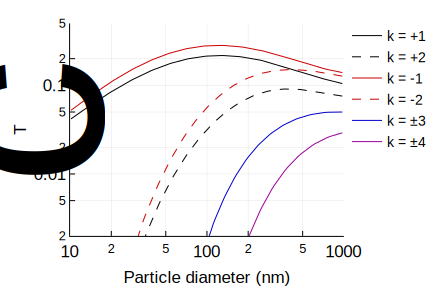

In [8]:
plot(δ.Dp, δ.Tc(1,δ.Dp), xscale = :log10, yscale = :log10, ylim = (0.002, 0.5), color = :black, xlim = (10,1000),
    yticks = [0.01, 0.1, 1.0], ylabel = "T<sub>c</sub> (-)",xlabel = "Particle diameter (nm)", label = "k = +1",)
plot!(δ.Dp,   δ.Tc(2,δ.Dp), label = "k = +2", color = :black, ls = :dash)
plot!(δ.Dp,  δp.Tc(1,δ.Dp), label = "k = -1", color = RGBA(0.8,0,0,1))
plot!(δp.Dp, δp.Tc(2,δ.Dp), label = "k = -2", color = RGBA(0.8,0,0,1), ls = :dash)
plot!(δp.Dp, δp.Tc(3,δ.Dp), label = "k = ±3", color = RGBA(0,0,0.8,1))
plot!(δp.Dp, δp.Tc(4,δ.Dp), label = "k = ±4", color = RGBA(0.6,0,0.6,1),fmt=:svg)

<b> Figure 5. </b> Size dependence of fractional charging efficiency of through the bipolar charger. Also see Figure B6 and Table B1 in the TSI Manual (2009).

### (f) DMA transfer function
The DMA transfer function is the probability that a particle of a particle of a given size exits the classifier via the sample flow. The diffusive broadened DMA transfer function is computed assuming blanced sheath and excess flows using the expression of Stolzenburg and McMurry (2008).
<center> $ \Omega(\tilde{z},\beta,\sigma) = \frac{\sigma}{\sqrt{2}\beta}\left[\epsilon \left( \frac{\tilde{z}-(1+\beta)}{\sqrt{2}\sigma} \right) + \epsilon \left (\frac{\tilde{z}-(1-\beta)}{\sqrt{2}\sigma} \right) - 2\epsilon \left ( \frac{\tilde{z}-1}{\sqrt{2}\sigma}\right)  \right]$ </center>
    
where $\tilde{z} = \frac{z}{z^s}$ is the dimensionless mobility, $z$ is the particle mobility $z^s$ is the centroid mobility selected by the DMA, $\epsilon = x \mathrm{erf}(x) +\left(\exp(-x^2)/\sqrt{\pi}\right)$, $\mathrm{erf}$ is the error function, and $\beta = \frac{q_{sa}}{q_{sh}}$. The parameter $\sigma$ accounts for diffusional broading of the transfer function. Assuming plug flow, $\sigma$ can be computed using the following equations Hagwood (1999) <br> <br>
$\gamma = \left(\frac{r_1}{r_2}\right)^2$ <br>
$I = \frac{1}{2}(1+γ)$ <br>
$\kappa = \frac{lr_2}{r_2^2-r_1^2}$ <br>
$G = \frac{4(1+\beta)^2}{(1-γ)} \left[I+\{2(1+\beta)\kappa\}^{-2} \right ] $<br>
$\sigma = \sqrt{\frac{2G\pi ld_{ab}}{q_{sh}}}$ <br> <br>
The function ```δ.Ω(Λ,z,zˢ)``` is implemented in dmafunctions.jl. Inputs include a DMA structure that conveys {t, p, and flow rates}, a mobility vector scalar z or vector Z, and a centroid mobility zˢ . 	

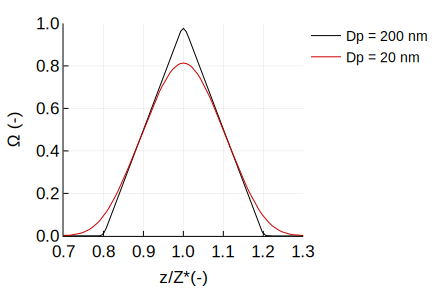

In [9]:
Z = exp10.(range(log10(1e-9), stop=log10(1e-6), length=1000)) # Fine grain mobility grid 
zˢ = dtoz(Λ, 200e-9)                           # Convert diameter to mobility
plot(Z/zˢ, δ.Ω(Λ,Z,zˢ), ylabel = "Ω (-)", xlim = (0.7, 1.3), ylim = (0,1), xlabel = "z/Z*(-)", color = :black,
    left_margin = 33px, label = "Dp = 200 nm", xticks = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
zˢ = dtoz(Λ, 20e-9)
p4 = plot!(Z/zˢ, δ.Ω(Λ,Z,zˢ), label = "Dp = 20 nm", color = RGBA(0.8,0,0,1),fmt=:svg)

<b> Figure 6. </b> Example normalized DMA transfer function for flow ratio $\beta$ = 1/5 (Block 1) and 20 and 200 nm particles. Also see to Fig. 2 and Fig. 4 in Stolzenburg and McMurry (2008).

### (g) SMPS Transfer Function
During operation as scanning mobility particles, the voltage continously changes. Signal is acquired during some discrete time interval $t_c$. The SMPS transfer function is calculated as the average transfer function during the time interval $[t,t+t_c]$ (Wang and Flagan). <br> <br>

<center> $\bar{\Omega} = \frac{1}{tc}\int_{t_i}^{t_i+t_c} \Omega(Z,z^s(t)) dt$ </center>

where $t_i$ is the start time when counting begins in channel $i$, $z^s(t)$ is the selected centroid mobility at time t and is calculated from the applied voltage as in (c) above. The voltage is usually varied exponentially with time from high-to-low (downscan) or low-high (upscan). The average transfer function is obtained by numerical integration as illustrated below.

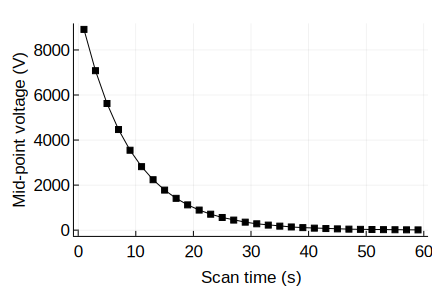

In [10]:
tscan = 60                 # 60 second SMPS scan
tc = 2.0                   # 2 second integration time per channel
vmin,vmax = 10,10000       # Scan from 10V to 10kV
bins = round(Int,tscan/tc) # Number of size bins
Ve = reverse(exp10.(range(log10(vmin), stop=log10(vmax), length=bins+1)))  # Voltage bin-edges, down scan 
Vp = sqrt.(Ve[2:end].*Ve[1:end-1])  # Voltage midpoints
t = 1:tc:tscan                      # Time array
plot(t,Vp, marker = :square, legend = :none, xlabel = "Scan time (s)", ylabel = "Mid-point voltage (V)",
     ms = :3, color = :black,fmt=:svg)

__Figure 7.__ Exponential voltage downscan for tscan = 60 s and tc = 2 s.

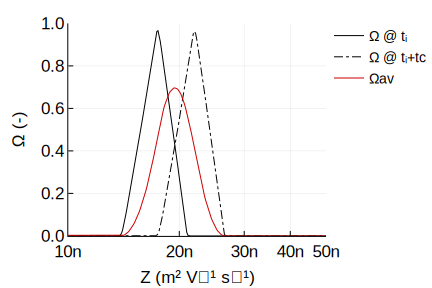

In [11]:
Zˢ = vtoz(Λ, Ve);     # Vector of mobility centroids for bin edges
i = 10;               # Bin number to obtain average transfer function
nint = 20             # Number of points for numerical integration

# Numerical integration over all transfer functions in the bin
Vex = reverse(exp10.(range(log10(Ve[i+1]), stop=log10(Ve[i]), length=nint)))
Ωav = mapreduce(zˢ->δ.Ω(Λ,Z,zˢ), +, vtoz(Λ, Vex))/nint

plot(Z, δ.Ω(Λ,Z,Zˢ[i]), ylabel = "Ω (-)", ylim = (0,1), xlabel = "Z (m² V⁻¹ s⁻¹)", color = :black,
    left_margin = 33px, label = "Ω @ tᵢ", xaxis = :log10, xlim = (10e-9, 50e-9))
plot!(Z, δ.Ω(Λ,Z,Zˢ[i+1]), label = "Ω @ tᵢ+tc", color = :black, ls = :dashdot)
plot!(Z,Ωav, color = RGBA(0.8,0,0,1), label = "Ωav",fmt=:svg)

__Figure 8.__ SMPS transfer function Ωav tscan = 60 s and tc = 2 s.

## References

Hagwood, C. (1999) The DMA Transfer Function with Brownian
Motion a Trajectory/Monte-Carlo Approach, Aerosol Science & Technology, 30:1, 40-61, DOI:10.1080/027868299304877

Hinds, W. C. (1999) Aerosol Technology, Properties, Behavior, and Measurement of Airborne Particles, Second Edition, John Wiley & Sons, Inc.

Knutson, E. O. & K. T. Whitby (1975) Aerosol classification by electric mobility:
Apparatus, theory, and applications. J. Aerosol Sci. (6)443-451, DOI:10.1016/0021-8502(75)90060-9

Reineking A. & J. Porstendörfer (1986) Measurements of Particle Loss Functions in a Differential Mobility Analyzer (TSI, Model 3071) for Different Flow Rates, Aerosol Science and Technology, 5:4, 483-486, DOI:10.1080/02786828608959112

Stolzenburg, M. R. & P. H. McMurry (2008) Equations Governing Single and Tandem DMA Configurations and a New Lognormal Approximation to the Transfer Function, Aerosol Science and Technology, 42:6, 421-432, DOI: 10.1080/02786820802157823

Wang, S. C. and Flagan, R. C. (1990). Scanning electrical mobility spectrometer.
Aerosol Science and Technology, 13:2, 230–240.

Wiedensohler, A. (1988) An approximation of the bipolar charge distribution for particles in the submicron size range, Journal of Aerosol Science, 19:3, 387-389, DOI:10.1016/0021-8502(88)90278-9

TSI Inc. (2009) Series 3080 Electrostatic Classifiers. Operation and Service Manual, P/N 1933792, Revision J March 2009. 